# 提取印刷体文本

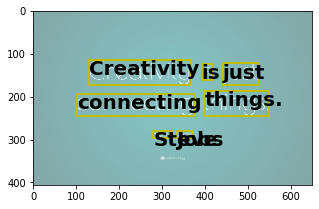

(0.0, 1.0, 0.0, 1.0)

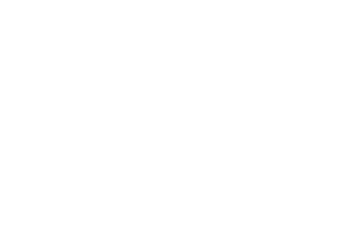

In [5]:
import os
import sys
import requests
# If you are using a Jupyter notebook, uncomment the following line.
# %matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from PIL import Image
from io import BytesIO

endpoint = "https://westcentralus.api.cognitive.microsoft.com/"
# if 'COMPUTER_VISION_ENDPOINT' in os.environ:
#     endpoint = os.environ['COMPUTER_VISION_ENDPOINT']
subscription_key = "4f5d16d33eb94213bef455ebe43e9cf9"

ocr_url = endpoint + "vision/v2.1/ocr"

# Set image_url to the URL of an image that you want to analyze.
image_url = "https://timgsa.baidu.com/timg?image&quality=80&size=b9999_10000&sec=1586371043455&di=c1e69554cb376ec92b9221376b78f7d6&imgtype=0&src=http%3A%2F%2Fimg0.imgtn.bdimg.com%2Fit%2Fu%3D173808385%2C3905026884%26fm%3D214%26gp%3D0.jpg"

headers = {'Ocp-Apim-Subscription-Key': subscription_key}
params = {'language': 'unk', 'detectOrientation': 'true'}
data = {'url': image_url}
response = requests.post(ocr_url, headers=headers, params=params, json=data)
response.raise_for_status()

analysis = response.json()

# Extract the word bounding boxes and text.
line_infos = [region["lines"] for region in analysis["regions"]]
word_infos = []
for line in line_infos:
    for word_metadata in line:
        for word_info in word_metadata["words"]:
            word_infos.append(word_info)
word_infos

# Display the image and overlay it with the extracted text.
plt.figure(figsize=(5, 5))
image = Image.open(BytesIO(requests.get(image_url).content))
ax = plt.imshow(image, alpha=0.5)
for word in word_infos:
    bbox = [int(num) for num in word["boundingBox"].split(",")]
    text = word["text"]
    origin = (bbox[0], bbox[1])
    patch = Rectangle(origin, bbox[2], bbox[3],
                      fill=False, linewidth=2, color='y')
    ax.axes.add_patch(patch)
    plt.text(origin[0], origin[1], text, fontsize=20, weight="bold", va="top")
plt.show()
plt.axis("off")

# 提取手写体文本

{'status': 'Succeeded', 'recognitionResults': [{'page': 1, 'clockwiseOrientation': 359.78, 'width': 546, 'height': 377, 'unit': 'pixel', 'lines': [{'boundingBox': [29, 0, 483, 0, 482, 20, 28, 17], 'text': 'Flow is everything going ? As you are interested in the', 'words': [{'boundingBox': [33, 0, 64, 0, 64, 13, 33, 11], 'text': 'Flow', 'confidence': 'Low'}, {'boundingBox': [79, 0, 94, 0, 93, 14, 79, 14], 'text': 'is'}, {'boundingBox': [102, 0, 186, 0, 185, 17, 101, 15], 'text': 'everything'}, {'boundingBox': [194, 0, 236, 0, 236, 18, 194, 17], 'text': 'going'}, {'boundingBox': [245, 0, 253, 0, 252, 18, 245, 18], 'text': '?', 'confidence': 'Low'}, {'boundingBox': [258, 0, 278, 0, 277, 19, 258, 19], 'text': 'As'}, {'boundingBox': [284, 0, 311, 0, 311, 19, 284, 19], 'text': 'you'}, {'boundingBox': [318, 0, 342, 0, 342, 19, 317, 19], 'text': 'are'}, {'boundingBox': [349, 0, 424, 0, 423, 18, 348, 19], 'text': 'interested'}, {'boundingBox': [432, 0, 445, 1, 445, 18, 431, 18], 'text': 'in'}, 

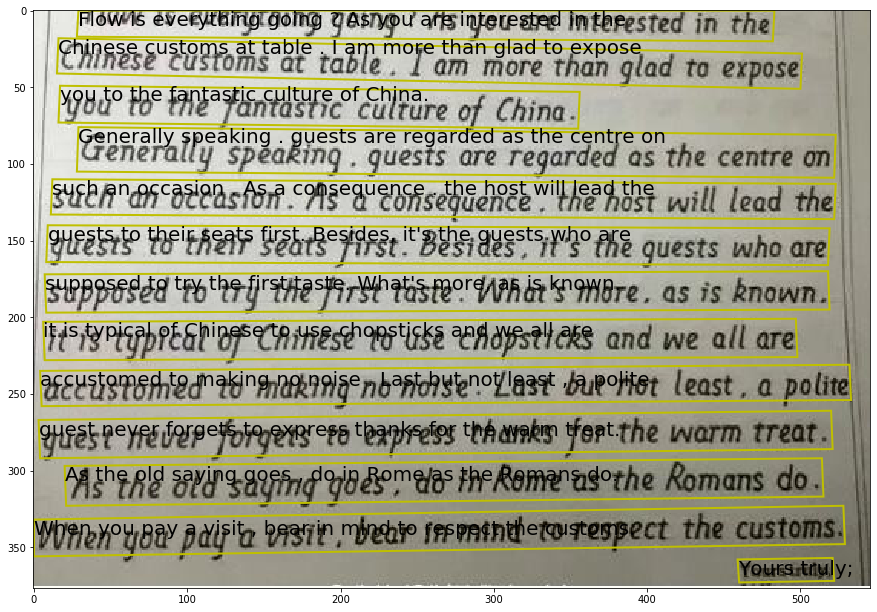

In [86]:
import os
import sys
import requests
import time
# If you are using a Jupyter notebook, uncomment the following line.
# %matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from PIL import Image
from io import BytesIO

# Add your Computer Vision subscription key and endpoint to your environment variables.

endpoint = "https://westcentralus.api.cognitive.microsoft.com/"
# if 'COMPUTER_VISION_ENDPOINT' in os.environ:
#     endpoint = os.environ['COMPUTER_VISION_ENDPOINT']
subscription_key = "4f5d16d33eb94213bef455ebe43e9cf9"
text_recognition_url = endpoint + "vision/v2.1/read/core/asyncBatchAnalyze"

# Set image_url to the URL of an image that you want to analyze.
image_url = "https://timgsa.baidu.com/timg?image&quality=80&size=b9999_10000&sec=1586370760768&di=95e324b2a58f6cf762e2a4a8f2949cca&imgtype=0&src=http%3A%2F%2Fp1.so.qhimgs1.com%2Ft01e1d7ae0d7c80b8d1.jpg"

headers = {'Ocp-Apim-Subscription-Key': subscription_key}
data = {'url': image_url}
response = requests.post(
    text_recognition_url, headers=headers, json=data)
response.raise_for_status()

# Extracting text requires two API calls: One call to submit the
# image for processing, the other to retrieve the text found in the image.

# Holds the URI used to retrieve the recognized text.
operation_url = response.headers["Operation-Location"]

# The recognized text isn't immediately available, so poll to wait for completion.
analysis = {}
poll = True
while (poll):
    response_final = requests.get(
        response.headers["Operation-Location"], headers=headers)
    analysis = response_final.json()
    print(analysis)
    time.sleep(1)
    if ("recognitionResults" in analysis):
        poll = False
    if ("status" in analysis and analysis['status'] == 'Failed'):
        poll = False

polygons = []
if ("recognitionResults" in analysis):
    # Extract the recognized text, with bounding boxes.
    polygons = [(line["boundingBox"], line["text"])
                for line in analysis["recognitionResults"][0]["lines"]]

# Display the image and overlay it with the extracted text.
plt.figure(figsize=(15, 15))
image = Image.open(BytesIO(requests.get(image_url).content))
ax = plt.imshow(image)
for polygon in polygons:
    vertices = [(polygon[0][i], polygon[0][i+1])
                for i in range(0, len(polygon[0]), 2)]
    text = polygon[1]
    patch = Polygon(vertices, closed=True, fill=False, linewidth=2, color='y')
    ax.axes.add_patch(patch)
    plt.text(vertices[0][0], vertices[0][1], text, fontsize=20, va="top")

# Python 使用域模型

{'result': {'landmarks': [{'name': 'Statue of Liberty', 'confidence': 0.9428012371063232}]}, 'requestId': 'e95b7e63-7de1-49c0-9bd5-8833b3c2b326', 'metadata': {'width': 900, 'height': 1200, 'format': 'Jpeg'}}


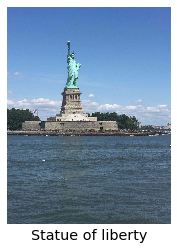

In [4]:
import os
import sys
import requests
# If you are using a Jupyter notebook, uncomment the following line.
# %matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image
from io import BytesIO

endpoint = "https://westcentralus.api.cognitive.microsoft.com/"
# if 'COMPUTER_VISION_ENDPOINT' in os.environ:
#     endpoint = os.environ['COMPUTER_VISION_ENDPOINT']
subscription_key = "4f5d16d33eb94213bef455ebe43e9cf9"
landmark_analyze_url = endpoint + "vision/v2.1/models/landmarks/analyze"

# Set image_url to the URL of an image that you want to analyze.
image_url = "https://timgsa.baidu.com/timg?image&quality=80&size=b9999_10000&sec=1586408652505&di=1f89b795d1ea810c220096334261a9b8&imgtype=0&src=http%3A%2F%2Fyouimg1.c-ctrip.com%2Ftarget%2Ffd%2Ftg%2Fg5%2FM05%2F5B%2FE2%2FCggYsFcgc8iAeEx-AAGlVfMCLXU915.jpg"

headers = {'Ocp-Apim-Subscription-Key': subscription_key}
params = {'model': 'landmarks'}
data = {'url': image_url}
response = requests.post(
    landmark_analyze_url, headers=headers, params=params, json=data)
response.raise_for_status()

# The 'analysis' object contains various fields that describe the image. The
# most relevant landmark for the image is obtained from the 'result' property.
analysis = response.json()
assert analysis["result"]["landmarks"] is not []
print(analysis)
landmark_name = analysis["result"]["landmarks"][0]["name"].capitalize()

# Display the image and overlay it with the landmark name.
image = Image.open(BytesIO(requests.get(image_url).content))
plt.imshow(image)
plt.axis("off")
_ = plt.title(landmark_name, size="x-large", y=-0.1)